# Llama深入浅出

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源码。

前方干货预警：这可能是你能够找到的最容易懂的最具实操性的学习开源LLM模型源码的教程。

本例从零开始基于transformers库逐模块搭建和解读Llama模型源码(中文可以翻译成羊驼)。

并且训练它来实现一个有趣的实例：两数之和。

输入输出类似如下：

输入："<SOS>12345+54321="
    
输出："66666<EOS>"
    
我们把这个任务当做一个文本生成任务来进行。输入是一个序列的上半部分，输出其下半部分.

这和文本生成的输入输出结构是类似的，所以可以用Llama来做。


目前大部分开源LLM模型都是基于transformers库来做的，它们的结构大部分都和Llama大同小异。

俗话说，魔鬼隐藏在细节中，深入理解Llama模型的的源码细节，将会帮助你打通和开源LLM模型相关的基础原理(如旋转位置编码以及长度外推)，并让你熟悉各种参数的配置和使用(如past_key_value，attention_mask的使用等等)。





## 一，准备数据

In [96]:
import random

import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader

# 定义字典
words = '<PAD>,<BOS>,<EOS>,1,2,3,4,5,6,7,8,9,0,+,='
vocab = {word: i for i, word in enumerate(words.split(','))}
vocab_r = [k for k, v in vocab.items()] #反查词典


In [113]:
#两数相加数据集
def get_data(min_length=10,max_length=20):
    # 定义词集合
    words = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    # 每个词被选中的概率
    p = np.array([7, 5, 5, 7, 6, 5, 7, 6, 5, 7])
    p = p / p.sum()

    # 随机采样n1个词作为s1
    n1 = random.randint(min_length, max_length)
    s1 = np.random.choice(words, size=n1, replace=True, p=p)
    s1 = s1.tolist()

    # 随机采样n2个词作为s2
    n2 = random.randint(min_length, max_length)
    s2 = np.random.choice(words, size=n2, replace=True, p=p)
    s2 = s2.tolist()

    # x等于s1和s2字符上的相加
    x = s1 + ['+'] + s2 + ['=']
    
    # y等于s1和s2数值上的相加
    y = int(''.join(s1)) + int(''.join(s2))
    y = list(str(y))
    
    # 加上首尾符号
    x = ['<BOS>'] + x 
    y =  y + ['<EOS>']
    
    return x,y

x,y = get_data() 
print(''.join(x)+''.join(y),"\n")



<BOS>3914835626735057733+318829464988=3914835945564522721<EOS> 



In [114]:
# 定义数据集
class TwoSumDataset(torch.utils.data.Dataset):
    def __init__(self,size = 100000, min_length=10,max_length=20):
        super(Dataset, self).__init__()
        self.size = size
        self.min_length=min_length
        self.max_length=max_length

    def __len__(self):
        return self.size

    def __getitem__(self, i):
        x,y = self.get(i)
        
        # 编码成token
        context_ids = [vocab[i] for i in x]
        target_ids = [vocab[i] for i in y]
        
        input_ids = context_ids + target_ids
        
        #-100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
        labels = [-100]*len(context_ids)+ target_ids
        masks = [0 if t==vocab['<PAD>'] else 1 for t in input_ids]
        
        example = {'input_ids':input_ids,
                  'labels':labels,'attention_mask':masks}
        
        return example
    
    def get(self,i):
        return get_data(self.min_length,self.max_length)
    
    
    def show_example(self,example):
        input_ids,labels = example['input_ids'],example['labels']
        x = ''.join([vocab_r[a] for a,b in zip(input_ids,labels) if b==-100])
        y = ''.join([vocab_r[a] for a,b in zip(input_ids,labels) if b!=-100])
        print(x+y)
        
        
    
ds_train = TwoSumDataset(size = 100000,min_length=10,max_length=20)
ds_val = TwoSumDataset(size = 10000,min_length=10,max_length=20)
example = ds_train[0]
ds_train.show_example(example)


<BOS>12878683929048906366+11274414130675477=12889958343179581843<EOS>


In [118]:
def data_collator(examples: list):
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    masks_list = []
    
    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]
        masks = example['attention_mask']
        
        ids = [vocab['<PAD>']] * (longest - length)+ids 
        labs = [-100] * (longest - length)+labs
        masks = [0]*(longest - length)+masks
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))
        masks_list.append(torch.LongTensor(masks))
          
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    attention_mask = torch.stack(masks_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
        "attention_mask":attention_mask
    }

# 数据加载器
dl_train = DataLoader(dataset=ds_train,
         batch_size=200,
         drop_last=True,
         shuffle=True,
         collate_fn = data_collator        
        )

dl_val = DataLoader(dataset=ds_val,
         batch_size=200,
         drop_last=True,
         shuffle=False,
         collate_fn = data_collator  
        )



In [119]:
for batch in dl_train:
    break 

In [120]:
batch 

{'input_ids': tensor([[ 1, 11,  6,  ...,  7, 11,  2],
         [ 0,  1,  6,  ...,  5,  4,  2],
         [ 0,  1,  7,  ...,  8,  8,  2],
         ...,
         [ 0,  0,  0,  ..., 10, 11,  2],
         [ 0,  0,  0,  ..., 12,  3,  2],
         [ 0,  0,  0,  ..., 11, 12,  2]]),
 'labels': tensor([[-100, -100, -100,  ...,    7,   11,    2],
         [-100, -100, -100,  ...,    5,    4,    2],
         [-100, -100, -100,  ...,    8,    8,    2],
         ...,
         [-100, -100, -100,  ...,   10,   11,    2],
         [-100, -100, -100,  ...,   12,    3,    2],
         [-100, -100, -100,  ...,   11,   12,    2]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [0, 1, 1,  ..., 1, 1, 1],
         [0, 1, 1,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]])}

## 二，定义模型

下面，我们会像搭积木建城堡那样从低往高地构建LLaMA模型。

先构建4个基础组件：旋转位置编码，多头注意力、前馈网络、层归一化。类似用最基础的积木块搭建了 墙壁，房顶，房门，窗户 这样的模块。

然后用这4个基础组件构建中间成品: 解码层。类似用基础组件构建了房间。

接着用多个中间成品解码层的堆叠组装成了LlamaModel完整模型，相当于通过构建多个房间建成了城堡的主体结构。

最后我们在LlamaModel基础上设计了两种不同的输出head，一种是语言模型Head，得到了LlamaForCausalLM，可用于文本生成。

另外一种是分类head，得到了LlamaForSequenceClassification，可用于文本分类。

相当于我们在城堡主体结构完成的基础上设计了两种不同的装修风格，一种是加装了一些游乐设施以便用于商业活动，另一种则是加装了一些武器以便用于军事活动。




**************************************************************************************************************

1, 旋转位置编码: RoPE (使用旋转矩阵实现的绝对位置编码，可以起到相对位置编码的效果)

2, 多头注意力: LlamaAttention (用于融合不同token之间的信息)

3, 前馈网络: LlamaMLP (用于逐位置将多头注意力融合后的信息进行高维映射变换)

4, 层归一化: LlamaRMSNorm (用于稳定输入，相当于保持每个词向量的方向不变，但对模长标准化。)

**************************************************************************************************************

5, Llama解码层: LlamaDecoderLayer (同时具备信息融合，信息转换功能的基本结构单元)

*************************************************************************************************************

6, Llama解码器: LlamaModel (多个解码层的堆叠)

*************************************************************************************************************
7，Llama语言模型: LlamaForCausalLM (解码器加上语言模型head，可用于文本生成)

8，Llama分类模型: LlamaForSequenceClassification (解码器加上分类head，可用于文本分类)

**************************************************************************************************************



In [121]:
import math
from typing import List, Optional, Tuple, Union

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.activations import ACT2FN
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast, SequenceClassifierOutputWithPast
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import add_start_docstrings, add_start_docstrings_to_model_forward, logging, replace_return_docstrings

from transformers.models.llama.configuration_llama  import LlamaConfig
from transformers.models.llama.modeling_llama import LLAMA_INPUTS_DOCSTRING,LLAMA_START_DOCSTRING

logger = logging.get_logger('llama')

config = LlamaConfig(
    vocab_size=len(vocab),
    hidden_size=512,
    intermediate_size=2752,
    num_hidden_layers=8,
    num_attention_heads=16,
    hidden_act='silu',
    max_position_embeddings=128,
    initializer_range=0.02,
    rms_norm_eps=1e-06,
    use_cache=True,
    pad_token_id=0,
    bos_token_id=1,
    eos_token_id=2,
    tie_word_embeddings=False
) 


### 1，旋转位置编码 RoPE

旋转位置编码即使用旋转矩阵表示位置编码(Rotary Position Encoding),简称RoPE。

关于RoPE的3个核心要点知识如下：

- **RoPE的设计思想是使用绝对位置编码来达到相对位置编码的效果。**

- **RoPE的实现方式是使用旋转矩阵来表示绝对位置编码。**

- **使用NTK扩展方法可以让RoPE在短文本上训练并在长文本上做预测。**

参考文章：

《博采众长的旋转式位置编码》https://kexue.fm/archives/8265 

《RoPE是一种$\beta$进制编码》https://kexue.fm/archives/9675

（1）绝对位置编码和相对位置编码

位置编码一般可以分成绝对位置编码和相对位置编码。

绝对位置编码的优点是计算简单高效，缺点是一般效果不如相对位置编码。

相对位置编码的优点是效果较好，缺点是计算效率不如绝对位置编码。

绝对位置编码：$attention(\boldsymbol{x}_m,\boldsymbol{x}_n,m,n) = f(\boldsymbol{x}_m,\boldsymbol{x}_n,m,n)$

相对位置编码：$attention(\boldsymbol{x}_m,\boldsymbol{x}_n,m,n) = g(\boldsymbol{x}_m,\boldsymbol{x}_n,m-n)$

在相对位置编码中，注意力权重的结果仅仅和参与注意力计算的token向量的相对位置有关，不和绝对位置直接关联。

这符合NLP领域在序列长度方向上具有平移不变性的特点，所以相对位置编码一般效果会优于绝对位置编码。


不过绝对位置编码并非一无是处，绝对位置编码只需要初始化时对序列的每个位置(数量正比于序列长度)赋予位置编码即可，后续无需干预。

而相对位置编码要在计算过程中获取许多个(数量正比于序列长度平方)相对位置。

因此绝对位置编码更加简单高效。

（2）使用旋转矩阵表示位置编码

上述讨论可以看到，绝对位置编码和相对位置编码互有优劣，那么有没有什么办法能够对二者进行取长补短呢？

有的，这个方法就是RoPE，它的设计思想就是使用绝对位置编码来达到相对位置编码的效果。

那么旋转位置编码如何使用绝对位置编码来达到相对位置编码的效果的呢？答案是使用旋转矩阵来表示位置编码。

$attention(\boldsymbol{x}_m,\boldsymbol{x}_n,m,n) = f(\boldsymbol{x}_m,\boldsymbol{x}_n,m,n)$

$f(\boldsymbol{x}_m,\boldsymbol{x}_n,m,n) \propto \langle p(\boldsymbol{x}_m,m),p(\boldsymbol{x}_n,n) \rangle$

$p(\boldsymbol{x}_k,k) = \boldsymbol{R}(k)\boldsymbol{x}_k$

其中 $\boldsymbol{R}(k)$为旋转矩阵，满足性质 $\boldsymbol{R}(m)^T\boldsymbol{R}(n)=\boldsymbol{R}(n-m)$。于是，有：
$$\langle p(\boldsymbol{x}_m,m),p(\boldsymbol{x}_n,n) \rangle = 
(\boldsymbol{R}(m)\boldsymbol{x}_m)^T  (\boldsymbol{R}(n)\boldsymbol{x}_n)
=\boldsymbol{x}_m^T \boldsymbol{R}(n-m)\boldsymbol{x}_n 
$$

$\boldsymbol{x}_m^T \boldsymbol{R}(n-m)\boldsymbol{x}_n$ 符合 $g(\boldsymbol{x}_m,\boldsymbol{x}_n,m-n)$ 相对位置编码形式。

perfect! 我们用绝对位置编码实现了相对位置编码的效果。


那么，旋转矩阵长什么样呢？

在二维情形长下面样子。

$$\boldsymbol{R}(k) = \left(\begin{array}{cc}
\cos k \theta & -\sin k \theta \\
\sin k \theta & \cos k \theta
\end{array}\right)$$

在NLP领域，词向量的维度一般会很高（例如4096）。

利用矩阵的分块思想，可以证明高维情形下扩展成下述形式依旧满足旋转矩阵性质$\boldsymbol{R}(m)^T\boldsymbol{R}(n)=\boldsymbol{R}(-m+n)$ 

$$
\boldsymbol{R}(k) = \left(\begin{array}{ccccccc}
\cos k \theta_{0} & -\sin k \theta_{0} & 0 & 0 & \cdots & 0 & 0 \\
\sin k \theta_{0} & \cos k \theta_{0} & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & \cos k \theta_{1} & -\sin k \theta_{1} & \ldots & 0 & 0 \\
0 & 0 & \sin k \theta_{1} & \cos k \theta_{1} & \ldots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \ldots & \cos k \theta_{d / 2-1} & -\sin k \theta_{d / 2-1} \\
0 & 0 & 0 & 0 & \ldots & \sin k \theta_{d / 2-1} & \cos k \theta_{d / 2-1}
\end{array}\right)
$$

其中 $\theta_i = 10000^{-2i/d}$，即越高的维度对应三角函数$sin(\theta_{i} k)$的系数越小，周期越大，变化越缓慢。


由于旋转矩阵是稀疏矩阵，直接使用乘法计算会很浪费算力，可以将旋转位置编码过程由矩阵乘法运算简化成两次向量的哈达玛积求和。

$$\boldsymbol{R}(k)\boldsymbol{x} = 
\left(\begin{array}{l}
\cos k \theta_{0} \\
\cos k \theta_{0} \\
\cos k \theta_{1} \\
\cos k \theta_{1} \\
\vdots \\
\cos k \theta_{d / 2-1} \\
\cos k \theta_{d / 2-1} \\
\end{array}\right)
\circ
\left(\begin{array}{l}
x_{0} \\
x_{1} \\
x_{2} \\
x_{3} \\
\vdots \\
x_{d-1} \\
x_{d} \\
\end{array}\right)
+
\left(\begin{array}{l}
\sin k \theta_{0} \\
\sin k \theta_{0} \\
\sin k \theta_{1} \\
\sin k \theta_{1} \\
\vdots \\
\sin k \theta_{d / 2-1} \\
\sin k \theta_{d / 2-1} \\
\end{array}\right)
\circ
\left(\begin{array}{l}
-x_{1} \\
x_{0} \\
-x_{3} \\
x_{2} \\
\vdots \\
-x_{d} \\
x_{d-1} \\
\end{array}\right)
$$


（3）旋转位置编码的长度扩展

在LLM的应用中，有一个非常重要的参数，叫做LLM支持的上下文长度(max context length)。

更长的上下文长度允许我们进行更多轮次的对话，允许我们对更长的本文进行总结分析，也允许我们生成更长的文章。

但是在训练LLM的时候，我们的训练语料大部分是不够长的，许多LLM训练时候设计的最大文本长度都是只有2k，也就是最长2048个token。

那么，能否在训练的时候使用较短的文本，而在推理的时候扩展到长文本上呢？

是有可能的，我们可以对RoPE进行长度扩展。

我们介绍3种扩展方案。

第一种是直接外推：直接外推其实就是继续沿用现有的位置编码公式，不做任何修改。

在扩展长度不太长的时候，例如由2k扩展到2.5k时，这种方法可能对性能的影响并不大。

因为旋转位置编码只和相对位置m-n的大小有关，一般具有远程衰减性，即相对距离越大的两个token，其相关性一般越弱。

因此如果我们的模型已经从训练数据那里学习到了token之间的相关性相对于相对距离在0-2k的一个合适的衰减规律的时候，可以设想把这个规律应用到0-2.5k也是没有太大的问题的。

但是如果我们要扩展到更长的长度，例如从2k扩展到32k，这种直接外推的方案通常会严重地影响性能。因为我们学习到的衰减规律有可能在5k的那里就完全衰减截断基本降为0了，这样我们就无法捕捉相对距离长于5k的两个token之间的相互作用，外推就会导致性能下降。

总结一下，直接外推对衰减规律在长距离情况下的使用容易出现问题，导致性能下降。

为了减少长度外推对性能的影响，我们可以让训练好的模型在更长的上下文上做少许步骤的微调。

第二种是线性内插：线性内插需要改变位置编码公式，等效于将位置序号等比例缩小。

编码公式变化如 $\cos(k\theta_i) \to \cos(k\theta_i/\lambda)$，当从2k扩展到32k，等效于需要将位置序号变成原来的1/16.

线性内插没有改变模型学习到的衰减规律的应用范围，不考虑微调的话，其效果一般好于直接外推方案。

但是，扩展倍数非常大的时候，例如从2k扩展到32k，其性能也会明显的受到影响。

因为在这种情况下，衰减规律在短距离情况下的使用会受到较严重的影响，本来距离为1的两个token，长度扩展后相当于变成了距离为1/16，衰减规律在短距离时可能具有非常大的变化率，因此对相关性的评估可能会极端地偏离合理值。

应用线性内插时，在长文本上做少许步骤的微调也能够明显地改善性能。

第三种是NTK扩展方式：这种方式综合了外推和内插的优点，做长度扩展后即使不微调也能够保持较好的性能。

前面的分析我们知道直接外推对衰减规律在长距离情况下的使用容易出问题，在短距离情况下的使用不受影响。

而线性内插对衰减规律在短距离情况下的使用容易出现问题，在长距离的情况下影响较小。

我们能否将它们综合起来，在短距离情况下具有外推特性(与扩展前基本一致)，在长距离情况下具有内插特性(缩放到扩展前的范围)，从而使得长距离情况下和短距离情况下衰减规律的使用都不太受到影响呢。

我们观察RoPE位置编码第$i$行的元素计算公式 $\cos(k \theta_{i}) = \cos(k 10000^{-2i/d})$，可以发现$i$越大，三角函数对应的角频率系数$\theta_{i}$越小，或者说越低频，对应的三角函数变化越慢。

容易得到如下直观结论：短距离之间的差异(例如1和5的差异)，主要体现在高频分量(i比较小)上，长距离之间的差异(例如5000和10000的差异)，主要体现在低频分量(i比较大)上。

为了在短距离情况下具有外推特性，而在长距离情况下具有内插特性，我们可以设计一个和$i$有关的位置序号缩放因子$\lambda(i)$，使得$\lambda(i)$在最高频($i=0$)时取值为1(与扩展前基本一致)，而在最低频时($i=d/2-1$)恰好为缩放倍数的倒数$1/s$(缩放到扩展前的范围)。

一种有效的选择方案是$i$的指数函数，其效果相当于对$\cos(k \theta_{i}) = \cos(k 10000^{-2i/d})$中的$10000$做一个缩放，根据边界条件容易求得合适的缩放因子为 $ s^{\frac{d}{d-2}} $ 。

NTK扩展方式的要点是高频外推，低频内插，实现方法是直接对底数base进行缩放，类似进制编码转换。

采用NTK扩展到长文本，即使不做微调，性能会只会略有下降。




下面是RoPE以及三种长度扩展方式的实现。

In [122]:
class LlamaRotaryEmbedding(torch.nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False) #persistent=False将不会作为state_dict

        # Build here to make `torch.jit.trace` work.
        self._set_cos_sin_cache(
            seq_len=max_position_embeddings, device=self.inv_freq.device, dtype=torch.get_default_dtype()
        )

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(self.max_seq_len_cached, device=device, dtype=self.inv_freq.dtype)

        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos()[None, None, :, :].to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin()[None, None, :, :].to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        #超过预设的max_position_embeddings则重新计算更大的Rope缓存，否则直接在缓存上切片
        if seq_len > self.max_seq_len_cached: 
            self._set_cos_sin_cache(seq_len=seq_len, device=x.device, dtype=x.dtype)

        return (
            self.cos_cached[:, :, :seq_len, ...].to(dtype=x.dtype),
            self.sin_cached[:, :, :seq_len, ...].to(dtype=x.dtype),
        )

    
class LlamaLinearScalingRotaryEmbedding(LlamaRotaryEmbedding):
    """LlamaRotaryEmbedding extended with linear scaling. Credits to the Reddit user /u/kaiokendev"""

    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None, scaling_factor=1.0):
        self.scaling_factor = scaling_factor
        super().__init__(dim, max_position_embeddings, base, device)

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(self.max_seq_len_cached, device=device, dtype=self.inv_freq.dtype)
        t = t / self.scaling_factor #线性内插相当于将位置序号等比例缩小

        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos()[None, None, :, :].to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin()[None, None, :, :].to(dtype), persistent=False)


class LlamaDynamicNTKScalingRotaryEmbedding(LlamaRotaryEmbedding):
    """LlamaRotaryEmbedding extended with Dynamic NTK scaling. Credits to the Reddit users /u/bloc97 and /u/emozilla"""

    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None, scaling_factor=1.0):
        self.scaling_factor = scaling_factor
        super().__init__(dim, max_position_embeddings, base, device)

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len

        if seq_len > self.max_position_embeddings:
            base = self.base * (
                (self.scaling_factor * seq_len / self.max_position_embeddings) - (self.scaling_factor - 1)
            ) ** (self.dim / (self.dim - 2))  #NTK扩展方式直接对base进行缩放
            inv_freq = 1.0 / (base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim))
            self.register_buffer("inv_freq", inv_freq, persistent=False)

        t = torch.arange(self.max_seq_len_cached, device=device, dtype=self.inv_freq.dtype)

        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        
        #此处处理逻辑与原始的ROPE有差异，原始逻辑如下
        #emb = torch.cat((freqs, freqs), dim=-1)
        #emb[...,0::2]=freqs
        #emb[...,1::2]=freqs
        
        
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos()[None, None, :, :].to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin()[None, None, :, :].to(dtype), persistent=False)
        
        
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    
    #此处逻辑与原始的ROPE有所差异，原始逻辑如下
    #x1 = x[..., 0::2] 
    #x2 = x[..., 1::2]
    #res = torch.cat((x1, x2), dim=-1)
    #res[...,0::2]=-x2
    #res[...,1::2]=x1
    #return res
    
    x1 = x[..., : x.shape[-1] // 2] 
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


In [123]:
x = torch.randn(1,8,4,2)
rope = LlamaRotaryEmbedding(dim=8)
cos,sin = rope.forward(x,seq_len=4)
print(cos.shape) 
print(cos)

torch.Size([1, 1, 4, 8])
tensor([[[[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
            1.0000],
          [ 0.5403,  0.9950,  0.9999,  1.0000,  0.5403,  0.9950,  0.9999,
            1.0000],
          [-0.4161,  0.9801,  0.9998,  1.0000, -0.4161,  0.9801,  0.9998,
            1.0000],
          [-0.9900,  0.9553,  0.9996,  1.0000, -0.9900,  0.9553,  0.9996,
            1.0000]]]])


### 2，多头注意力 LlamaAttention

这里的LlamaAttention 基本上和《Attention Is All You Need》论文里的是一致的，主要差异有以下一些。

1，k和v的head数量可以是q的head数量的几分之一，类似分组卷积的思想，可以减少参数规模。

2，rope位置编码是每次做多头注意力时都进行一次，而不是原论文只在输入的时候进行一次。

3，允许传入key和value的states的缓存past_key_value，这在多轮对话中可以减少重复计算，起到加速效果。

4，attention_mask是通过加法形式作用到softmax之前的attention矩阵上的。



In [124]:
def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


class LlamaAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: LlamaConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.max_position_embeddings = config.max_position_embeddings

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )
        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=False)
        self._init_rope()

    def _init_rope(self):
        if self.config.rope_scaling is None:
            self.rotary_emb = LlamaRotaryEmbedding(self.head_dim, max_position_embeddings=self.max_position_embeddings)
        else:
            scaling_type = self.config.rope_scaling["type"]
            scaling_factor = self.config.rope_scaling["factor"]
            if scaling_type == "linear":
                self.rotary_emb = LlamaLinearScalingRotaryEmbedding(
                    self.head_dim, max_position_embeddings=self.max_position_embeddings, scaling_factor=scaling_factor
                )
            elif scaling_type == "dynamic":
                self.rotary_emb = LlamaDynamicNTKScalingRotaryEmbedding(
                    self.head_dim, max_position_embeddings=self.max_position_embeddings, scaling_factor=scaling_factor
                )
            else:
                raise ValueError(f"Unknown RoPE scaling type {scaling_type}")

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: bool = False,
        use_cache: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        bsz, q_len, _ = hidden_states.size()

        if self.config.pretraining_tp > 1:
            key_value_slicing = (self.num_key_value_heads * self.head_dim) // self.config.pretraining_tp
            query_slices = self.q_proj.weight.split(
                (self.num_heads * self.head_dim) // self.config.pretraining_tp, dim=0
            )
            key_slices = self.k_proj.weight.split(key_value_slicing, dim=0)
            value_slices = self.v_proj.weight.split(key_value_slicing, dim=0)

            query_states = [F.linear(hidden_states, query_slices[i]) for i in range(self.config.pretraining_tp)]
            query_states = torch.cat(query_states, dim=-1)

            key_states = [F.linear(hidden_states, key_slices[i]) for i in range(self.config.pretraining_tp)]
            key_states = torch.cat(key_states, dim=-1)

            value_states = [F.linear(hidden_states, value_slices[i]) for i in range(self.config.pretraining_tp)]
            value_states = torch.cat(value_states, dim=-1)

        else:
            query_states = self.q_proj(hidden_states)
            key_states = self.k_proj(hidden_states)
            value_states = self.v_proj(hidden_states)

        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        kv_seq_len = key_states.shape[-2]
        if past_key_value is not None:
            kv_seq_len += past_key_value[0].shape[-2]
        cos, sin = self.rotary_emb(value_states, seq_len=kv_seq_len)
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)

        if past_key_value is not None:
            # reuse k, v, self_attention
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)

        past_key_value = (key_states, value_states) if use_cache else None

        # repeat k/v heads if n_kv_heads < n_heads
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        if attn_weights.size() != (bsz, self.num_heads, q_len, kv_seq_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz, self.num_heads, q_len, kv_seq_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, q_len, kv_seq_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, q_len, kv_seq_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights + attention_mask

        # upcast attention to fp32
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(bsz, q_len, self.hidden_size)

        if self.config.pretraining_tp > 1:
            attn_output = attn_output.split(self.hidden_size // self.config.pretraining_tp, dim=2)
            o_proj_slices = self.o_proj.weight.split(self.hidden_size // self.config.pretraining_tp, dim=1)
            attn_output = sum([F.linear(attn_output[i], o_proj_slices[i]) for i in range(self.config.pretraining_tp)])
        else:
            attn_output = self.o_proj(attn_output)

        if not output_attentions:
            attn_weights = None

        return attn_output, attn_weights, past_key_value
    
    

### 3，前馈网络 LlamaMLP

前馈网络是一个2层的感知机MLP。

先从hidden_size维度up_proj到intermediate_size维度，然后再down_proj还原为hidden_size维度。

这里的主要特色是引入了一个gate_proj配合激活函数来实现一个门控注意力的作用。



In [125]:
class LlamaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.act_fn = ACT2FN[config.hidden_act]

    def forward(self, x):
        if self.config.pretraining_tp > 1:
            slice = self.intermediate_size // self.config.pretraining_tp
            gate_proj_slices = self.gate_proj.weight.split(slice, dim=0)
            up_proj_slices = self.up_proj.weight.split(slice, dim=0)
            down_proj_slices = self.down_proj.weight.split(slice, dim=1)

            gate_proj = torch.cat(
                [F.linear(x, gate_proj_slices[i]) for i in range(self.config.pretraining_tp)], dim=-1
            )
            up_proj = torch.cat([F.linear(x, up_proj_slices[i]) for i in range(self.config.pretraining_tp)], dim=-1)

            intermediate_states = (self.act_fn(gate_proj) * up_proj).split(slice, dim=2)
            down_proj = [
                F.linear(intermediate_states[i], down_proj_slices[i]) for i in range(self.config.pretraining_tp)
            ]
            down_proj = sum(down_proj)
        else:
            down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

        return down_proj


### 4，层归一化 LlamaRMSNorm

这里的层归一化叫做RMSNorm，和标准的LayerNorm有少许差异。

首先是没有移除均值，直接除的RootMeanSquare，然后也没有加上bias。

这两个小的修正可以保证在层归一化不会改变hidden_states对应的词向量的方向，只会改变其模长。

在一定的意义上具有合理性。




In [126]:
class LlamaRMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        LlamaRMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)
    

### 5，Llama解码层

解码层LlamaDecoderLayer由LlamaAttention，LlamaMLP，以及两个LlamaRMSNorm组成，并使用了两次残差结构。


In [127]:
class LlamaDecoderLayer(nn.Module):
    def __init__(self, config: LlamaConfig):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.self_attn = LlamaAttention(config=config)
        self.mlp = LlamaMLP(config)
        self.input_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`, *optional*): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            use_cache (`bool`, *optional*):
                If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding
                (see `past_key_values`).
            past_key_value (`Tuple(torch.FloatTensor)`, *optional*): cached past key and value projection states
        """

        residual = hidden_states

        hidden_states = self.input_layernorm(hidden_states)

        # Self Attention
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            output_attentions=output_attentions,
            use_cache=use_cache,
        )
        hidden_states = residual + hidden_states

        # Fully Connected
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights,)

        if use_cache:
            outputs += (present_key_value,)

        return outputs


### 6，Llama解码器

LlamaModel由多个Llama解码层堆叠而成。

有几个理解上的要点：

1，`_make_causal_mask`用于构造下三角这种mask结构以实现语言模型的单向注意力。

2，`_expand_mask`用于将传入的<pad>等特殊符号相关的mask信息展开成和attention矩阵相同的张量结构。

3，设置gradient_checkpointing=True可以节约显存。其主要应用了torch.utils.checkpoint.checkpoint方法。
它的原理非常简单，在对decoder_layer进行forward时不保存中间激活值从而节约显存，backward时重新计算相关值，从而通过时间换取了空间。

4，gradient_checkpointing和use_cache不能同时设置为True，前者是为了节约显存时间换空间的，后者是为了节约时间空间换时间。
    

In [128]:
# Copied from transformers.models.bart.modeling_bart._make_causal_mask
def _make_causal_mask(
    input_ids_shape: torch.Size, dtype: torch.dtype, 
    device: torch.device, past_key_values_length: int = 0
):
    """
    Make causal mask used for bi-directional self-attention.
    """
    bsz, tgt_len = input_ids_shape
    mask = torch.full((tgt_len, tgt_len), torch.finfo(dtype).min, device=device)
    mask_cond = torch.arange(mask.size(-1), device=device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)
    return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)


# Copied from transformers.models.bart.modeling_bart._expand_mask
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)
    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)


@add_start_docstrings(
    "The bare LLaMA Model outputting raw hidden-states without any specific head on top.",
    LLAMA_START_DOCSTRING,
)
class LlamaPreTrainedModel(PreTrainedModel):
    config_class = LlamaConfig
    base_model_prefix = "model"
    supports_gradient_checkpointing = True
    _no_split_modules = ["LlamaDecoderLayer"]
    _skip_keys_device_placement = "past_key_values"

    def _init_weights(self, module):
        std = self.config.initializer_range
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, LlamaModel):
            module.gradient_checkpointing = value


@add_start_docstrings(
    "The bare LLaMA Model outputting raw hidden-states without any specific head on top.",
    LLAMA_START_DOCSTRING,
)
class LlamaModel(LlamaPreTrainedModel):
    """
    Transformer decoder consisting of *config.num_hidden_layers* layers. Each layer is a [`LlamaDecoderLayer`]

    Args:
        config: LlamaConfig
    """

    def __init__(self, config: LlamaConfig):
        super().__init__(config)
        self.padding_idx = config.pad_token_id
        self.vocab_size = config.vocab_size

        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, self.padding_idx)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.norm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value

    # Copied from transformers.models.bart.modeling_bart.BartDecoder._prepare_decoder_attention_mask
    def _prepare_decoder_attention_mask(self, attention_mask, input_shape, inputs_embeds, past_key_values_length):
        # create causal mask
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        combined_attention_mask = None
        if input_shape[-1] > 1:
            combined_attention_mask = _make_causal_mask(
                input_shape,
                inputs_embeds.dtype,
                device=inputs_embeds.device,
                past_key_values_length=past_key_values_length,
            )

        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            expanded_attn_mask = _expand_mask(attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]).to(
                inputs_embeds.device
            )
            combined_attention_mask = (
                expanded_attn_mask if combined_attention_mask is None else expanded_attn_mask + combined_attention_mask
            )

        return combined_attention_mask

    @add_start_docstrings_to_model_forward(LLAMA_INPUTS_DOCSTRING)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPast]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time")
        elif input_ids is not None:
            batch_size, seq_length = input_ids.shape
        elif inputs_embeds is not None:
            batch_size, seq_length, _ = inputs_embeds.shape
        else:
            raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")

        seq_length_with_past = seq_length
        past_key_values_length = 0

        if past_key_values is not None:
            past_key_values_length = past_key_values[0][0].shape[2]
            seq_length_with_past = seq_length_with_past + past_key_values_length

        if position_ids is None:
            device = input_ids.device if input_ids is not None else inputs_embeds.device
            position_ids = torch.arange(
                past_key_values_length, seq_length + past_key_values_length, dtype=torch.long, device=device
            )
            position_ids = position_ids.unsqueeze(0).view(-1, seq_length)
        else:
            position_ids = position_ids.view(-1, seq_length).long()

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids)
        # embed positions
        if attention_mask is None:
            attention_mask = torch.ones(
                (batch_size, seq_length_with_past), dtype=torch.bool, device=inputs_embeds.device
            )
        attention_mask = self._prepare_decoder_attention_mask(
            attention_mask, (batch_size, seq_length), inputs_embeds, past_key_values_length
        )

        hidden_states = inputs_embeds

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        next_decoder_cache = () if use_cache else None

        for idx, decoder_layer in enumerate(self.layers):
            if output_hidden_states:
                all_hidden_states += (hidden_states,)

            past_key_value = past_key_values[idx] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        # None for past_key_value
                        return module(*inputs, output_attentions, None)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(decoder_layer),
                    hidden_states,
                    attention_mask,
                    position_ids,
                    None,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    position_ids=position_ids,
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )

            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[2 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

        hidden_states = self.norm(hidden_states)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(v for v in [hidden_states, next_cache, all_hidden_states, all_self_attns] if v is not None)
        return BaseModelOutputWithPast(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
        )


### 7，Llama语言模型

Llama语言模型 LlamaForCausalLM是在Llama解码器LlamaModel的基础上增加了一个lm_head作为Generator。

从而实现了一个完整的语言模型。

除此之外，Llama语言模型还实现了以下重要功能。

1，loss计算功能。当forward方法中传入labels时，会自动计算语言模型的交叉熵损失。注意labels中的-100会被忽略不参与计算。

2，文本生成generate方法。这个方法继承自PreTrainedModel，可以设置model.generation_config.num_beams选择束搜索的束宽度，默认为1即贪心搜索。



In [129]:
_CONFIG_FOR_DOC = "LlamaConfig"

class LlamaForCausalLM(LlamaPreTrainedModel):
    _tied_weights_keys = ["lm_head.weight"]

    def __init__(self, config):
        super().__init__(config)
        self.model = LlamaModel(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def set_input_embeddings(self, value):
        self.model.embed_tokens = value

    def get_output_embeddings(self):
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def set_decoder(self, decoder):
        self.model = decoder

    def get_decoder(self):
        return self.model

    @add_start_docstrings_to_model_forward(LLAMA_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=CausalLMOutputWithPast, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, CausalLMOutputWithPast]:
        r"""
        Args:
            labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
                config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
                (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

        Returns:

        Example:

        ```python
        >>> from transformers import AutoTokenizer, LlamaForCausalLM

        >>> model = LlamaForCausalLM.from_pretrained(PATH_TO_CONVERTED_WEIGHTS)
        >>> tokenizer = AutoTokenizer.from_pretrained(PATH_TO_CONVERTED_TOKENIZER)

        >>> prompt = "Hey, are you conscious? Can you talk to me?"
        >>> inputs = tokenizer(prompt, return_tensors="pt")

        >>> # Generate
        >>> generate_ids = model.generate(inputs.input_ids, max_length=30)
        >>> tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        "Hey, are you conscious? Can you talk to me?\nI'm not conscious, but I can talk to you."
        ```"""

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        if self.config.pretraining_tp > 1:
            lm_head_slices = self.lm_head.weight.split(self.vocab_size // self.config.pretraining_tp, dim=0)
            logits = [F.linear(hidden_states, lm_head_slices[i]) for i in range(self.config.pretraining_tp)]
            logits = torch.cat(logits, dim=-1)
        else:
            logits = self.lm_head(hidden_states)
        logits = logits.float()

        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            shift_logits = shift_logits.view(-1, self.config.vocab_size)
            shift_labels = shift_labels.view(-1)
            # Enable model parallelism
            shift_labels = shift_labels.to(shift_logits.device)
            loss = loss_fct(shift_logits, shift_labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return CausalLMOutputWithPast(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    def prepare_inputs_for_generation(
        self, input_ids, past_key_values=None, attention_mask=None, inputs_embeds=None, **kwargs
    ):
        if past_key_values:
            input_ids = input_ids[:, -1:]

        position_ids = kwargs.get("position_ids", None)
        if attention_mask is not None and position_ids is None:
            # create position_ids on the fly for batch generation
            position_ids = attention_mask.long().cumsum(-1) - 1
            position_ids.masked_fill_(attention_mask == 0, 1)
            if past_key_values:
                position_ids = position_ids[:, -1].unsqueeze(-1)

        # if `inputs_embeds` are passed, we only want to use them in the 1st generation step
        if inputs_embeds is not None and past_key_values is None:
            model_inputs = {"inputs_embeds": inputs_embeds}
        else:
            model_inputs = {"input_ids": input_ids}

        model_inputs.update(
            {
                "position_ids": position_ids,
                "past_key_values": past_key_values,
                "use_cache": kwargs.get("use_cache"),
                "attention_mask": attention_mask,
            }
        )
        return model_inputs

    @staticmethod
    def _reorder_cache(past_key_values, beam_idx):
        reordered_past = ()
        for layer_past in past_key_values:
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past),
            )
        return reordered_past


### 8，Llama分类模型

LlamaForSequenceClassification是一个序列分类模型。

这个分类模型可以用来训练RLHF流程中的Reward模型。

In [130]:
@add_start_docstrings(
    """
    The LLaMa Model transformer with a sequence classification head on top (linear layer).

    [`LlamaForSequenceClassification`] uses the last token in order to do the classification, as other causal models
    (e.g. GPT-2) do.

    Since it does classification on the last token, it requires to know the position of the last token. If a
    `pad_token_id` is defined in the configuration, it finds the last token that is not a padding token in each row. If
    no `pad_token_id` is defined, it simply takes the last value in each row of the batch. Since it cannot guess the
    padding tokens when `inputs_embeds` are passed instead of `input_ids`, it does the same (take the last value in
    each row of the batch).
    """,
    LLAMA_START_DOCSTRING,
)
class LlamaForSequenceClassification(LlamaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.model = LlamaModel(config)
        self.score = nn.Linear(config.hidden_size, self.num_labels, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def set_input_embeddings(self, value):
        self.model.embed_tokens = value

    @add_start_docstrings_to_model_forward(LLAMA_INPUTS_DOCSTRING)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutputWithPast]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = transformer_outputs[0]
        logits = self.score(hidden_states)

        if input_ids is not None:
            batch_size = input_ids.shape[0]
        else:
            batch_size = inputs_embeds.shape[0]

        if self.config.pad_token_id is None and batch_size != 1:
            raise ValueError("Cannot handle batch sizes > 1 if no padding token is defined.")
        if self.config.pad_token_id is None:
            sequence_lengths = -1
        else:
            if input_ids is not None:
                sequence_lengths = (torch.eq(input_ids, self.config.pad_token_id).long().argmax(-1) - 1).to(
                    logits.device
                )
            else:
                sequence_lengths = -1

        pooled_logits = logits[torch.arange(batch_size, device=logits.device), sequence_lengths]

        loss = None
        if labels is not None:
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(pooled_logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(pooled_logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(pooled_logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(pooled_logits, labels)
        if not return_dict:
            output = (pooled_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutputWithPast(
            loss=loss,
            logits=pooled_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )

## 三，训练模型

下面，我们来训练一个LlamaForCausalLM 实现两数之和的任务。

In [223]:
config = LlamaConfig(
    vocab_size=len(vocab),
    hidden_size=512,
    intermediate_size=2752,
    num_hidden_layers=8,
    num_attention_heads=16,
    num_key_value_heads=4,
    rope_scaling = None,
    hidden_act='silu',
    max_position_embeddings=128,
    initializer_range=0.02,
    rms_norm_eps=1e-06,
    use_cache=True,
    pad_token_id=0,
    bos_token_id=1,
    eos_token_id=2,
    tie_word_embeddings=False,
    pretraining_tp = 1,
    max_new_tokens = 100
) 


In [142]:
#试算一下
model = LlamaForCausalLM(config)
out = model.forward(**batch)
print(out.loss)

tensor(2.7630, grad_fn=<NllLossBackward0>)


In [140]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(**batch).loss

        #backward()
        if self.stage=="train" and self.optimizer is not None:        
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 



<<<<<< ⚡️ cuda is used >>>>>>


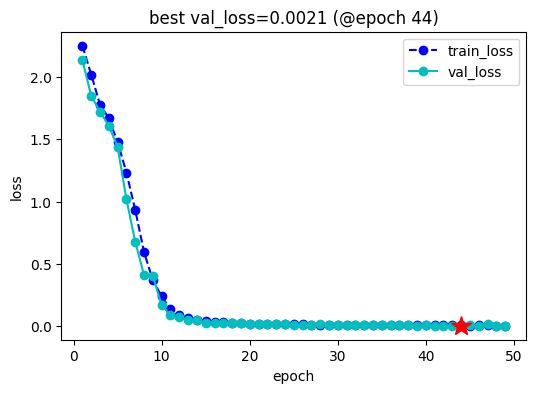

<<<<<< val_loss without improvement in 5 epoch,early stopping >>>>>> 



,epoch,train_loss,lr,val_loss
0,1,2.252255,0.00003,2.135870
1,2,2.020835,0.00003,1.849496
2,3,1.777852,0.00003,1.722345
3,4,1.669158,0.00003,1.607782
4,5,1.475423,0.00003,1.439040
5,6,1.233220,0.00003,1.017080
6,7,0.931248,0.00003,0.677400
7,8,0.593412,0.00003,0.407361
8,9,0.367539,0.00003,0.401502
9,10,0.237548,0.00003,0.166748


In [143]:
keras_model = KerasModel(model,loss_fn = None,
        optimizer=torch.optim.AdamW(model.parameters(),lr=3e-5))


#加载 之前训练过的权重
ckpt_path = 'llama_twosum'

keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,patience=5,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16'
               )


## 四，使用模型

In [250]:
from transformers.generation.utils import GenerationConfig
model.generation_config = GenerationConfig.from_dict({'num_beams':1,
                            'max_new_tokens':100,
                            'max_length':200})

In [251]:
model.generation_config.num_beams=1
model.generation_config.max_new_tokens = 100 
model.generation_config.max_length=200

In [238]:
def get_ans(tensor) ->"str":
    s = "".join([vocab_r[i] for i in tensor.tolist()])
    ans = s[s.find('=')+1:s.find('<EOS>')].replace('<BOS>','').replace('<EOS>','')
    return ans

In [240]:
x,y = get_data() 
print('x: '+''.join(x).replace('<BOS>',''))
print('y: '+''.join(y).replace('<EOS>',''))

x: 3481340050+90157504501803=
y: 90160985841853


In [241]:
input_ids = torch.tensor([[vocab[i] for i in x]]) 
out = model.generate(inputs=input_ids)

In [242]:
out 

tensor([[ 1,  5,  6, 10,  3,  5,  6, 12, 12,  7, 12, 13, 11, 12,  3,  7,  9,  7,
         12,  6,  7, 12,  3, 10, 12,  5, 14, 11, 12,  3,  8, 12, 11, 10,  7, 10,
          6,  3, 10,  7,  5,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 12,  2,  2,  2,  2,  2,  2,  2,
          2, 12,  3, 12,  3]])

In [243]:
get_ans(out[0])

'90160985841853'

## 五，评估模型

In [245]:
from tqdm import tqdm 


In [247]:
loop = tqdm(range(1,201))
correct = 0
for i in loop:
    x,y = get_data() 
    input_ids = torch.tensor([[vocab[i] for i in x]]) 
    out = model.generate(inputs=input_ids)
    pred = get_ans(out[0])
    gt = ''.join(y).replace('<EOS>','')
    if pred==gt:
        correct+=1
    loop.set_postfix(acc = correct/i)
    
print("acc=",correct/len(loop))

100%|██████████| 200/200 [04:25<00:00,  1.33s/it, acc=0.99] 

acc= 0.99


漂亮，我们的测试准确率达到了99%！


**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)

